In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

plt.style.use('seaborn-v0_8')


In [ ]:
df = pd.read_csv(
    "With_drift.csv",
    dtype={
        "bias_float64": np.float64,
        "drift_float64": np.float64,
        "t_seconds": np.float64,
        "drift_final": np.float64
    }
)

df['timestamp'] = pd.to_datetime(df['timestamp'])

df.head()



,timestamp,bias_float64,drift_float64,t_seconds,drift_final
0,2024-01-14 00:00:00,0.000797,4.534100e-12,0.0,4.534100e-12
1,2024-01-14 00:00:30,0.000797,NaN,30.0,4.538400e-12
2,2024-01-14 00:01:00,0.000797,NaN,60.0,4.542400e-12
3,2024-01-14 00:01:30,0.000797,NaN,90.0,4.546200e-12
4,2024-01-14 00:02:00,0.000797,NaN,120.0,4.549700e-12


In [ ]:
print(df['bias_float64'].iloc[0])

0.000797131593063


In [ ]:
# Bias Trend = linear fit
t = df['t_seconds'].values
bias = df['bias_float64'].values

coef = np.polyfit(t, bias, 1)
bias_trend = coef[0] * t + coef[1]

df['bias_trend'] = bias_trend
df['bias_residual'] = df['bias_float64'] - df['bias_trend']

df.head()


,timestamp,bias_float64,drift_float64,t_seconds,drift_final,bias_trend,bias_residual
0,2024-01-14 00:00:00,0.000797,4.534100e-12,0.0,4.534100e-12,0.000797,1.443761e-08
1,2024-01-14 00:00:30,0.000797,NaN,30.0,4.538400e-12,0.000797,1.440613e-08
2,2024-01-14 00:01:00,0.000797,NaN,60.0,4.542400e-12,0.000797,1.437619e-08
3,2024-01-14 00:01:30,0.000797,NaN,90.0,4.546200e-12,0.000797,1.437577e-08
4,2024-01-14 00:02:00,0.000797,NaN,120.0,4.549700e-12,0.000797,1.436284e-08


In [ ]:
train_mask = df['timestamp'] < "2024-01-20"
test_mask  = df['timestamp'] >= "2024-01-20"

df_train = df[train_mask].reset_index(drop=True)
df_test  = df[test_mask].reset_index(drop=True)

print(len(df_train), len(df_test))


17280 2880


In [ ]:
drift_scaler = MinMaxScaler()
resid_scaler = MinMaxScaler()

df_train['drift_scaled'] = drift_scaler.fit_transform(df_train['drift_final'].values.reshape(-1,1))
df_train['resid_scaled'] = resid_scaler.fit_transform(df_train['bias_residual'].values.reshape(-1,1))

df_test['drift_scaled'] = drift_scaler.transform(df_test['drift_final'].values.reshape(-1,1))
df_test['resid_scaled'] = resid_scaler.transform(df_test['bias_residual'].values.reshape(-1,1))


In [ ]:
def create_sequences(data, seq_len=10):
    X, y_drift, y_resid = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data['drift_scaled'].values[i:i+seq_len])
        y_drift.append(data['drift_scaled'].values[i+seq_len])
        y_resid.append(data['resid_scaled'].values[i+seq_len])
    return np.array(X, dtype=np.float64), \
           np.array(y_drift, dtype=np.float64), \
           np.array(y_resid, dtype=np.float64)


In [ ]:
SEQ_LEN = 10

X_train, y_train_drift, y_train_resid = create_sequences(df_train, SEQ_LEN)
X_test, y_test_drift,  y_test_resid  = create_sequences(df_test, SEQ_LEN)

X_train = X_train.reshape((-1, SEQ_LEN, 1))
X_test  = X_test.reshape((-1, SEQ_LEN, 1))


In [ ]:
inp = Input(shape=(SEQ_LEN,1))

x = LSTM(64, return_sequences=False)(inp)
x = Dense(32, activation='relu')(x)

# Two outputs
out_drift = Dense(1, name="drift_out")(x)
out_resid = Dense(1, name="resid_out")(x)

model = Model(inputs=inp, outputs=[out_drift, out_resid])
model.compile(optimizer="adam", loss="mse")

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     16,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drift_out (Dense)   │ (None, 1)         │         33 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resid_out (Dense)   │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,042 (74.38 KB)

 Trainable params: 19,042 (74.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train,
    [y_train_drift, y_train_resid],
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - drift_out_loss: 0.0090 - loss: 0.0864 - resid_out_loss: 0.0774 - val_drift_out_loss: 9.9123e-05 - val_loss: 0.0236 - val_resid_out_loss: 0.0235
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - drift_out_loss: 1.9185e-04 - loss: 0.0685 - resid_out_loss: 0.0683 - val_drift_out_loss: 5.1816e-05 - val_loss: 0.0157 - val_resid_out_loss: 0.0156
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - drift_out_loss: 2.3854e-04 - loss: 0.0691 - resid_out_loss: 0.0689 - val_drift_out_loss: 2.6627e-04 - val_loss: 0.0279 - val_resid_out_loss: 0.0277
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - drift_out_loss: 1.9747e-04 - loss: 0.0683 - resid_out_loss: 0.0681 - val_drift_out_loss: 1.7068e-04 - val_loss: 0.0165 - val_resid_out_loss: 0.0164
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - drift_out_loss: 1.6108e-04 - loss: 0.0686 - resid_out_loss: 0.0685 - val_drift_out_loss: 2.0808e-04 - val_loss: 0.0093 - val_resid_out_loss: 0

In [ ]:
pred_drift_scaled, pred_resid_scaled = model.predict(X_test)

pred_drift = drift_scaler.inverse_transform(pred_drift_scaled)
true_drift = drift_scaler.inverse_transform(y_test_drift.reshape(-1,1))

pred_resid = resid_scaler.inverse_transform(pred_resid_scaled)
true_resid = resid_scaler.inverse_transform(y_test_resid.reshape(-1,1))

# Reconstruct bias
bias_trend_test = df_test['bias_trend'].values[SEQ_LEN:]
pred_bias = bias_trend_test + pred_resid.flatten()
true_bias = bias_trend_test + true_resid.flatten()


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
def metrics(a,b,name):
    print("\n---", name, "---")
    print("MSE :", mean_squared_error(a,b))
    print("MAE :", mean_absolute_error(a,b))
    print("RMSE:", np.sqrt(mean_squared_error(a,b)))
    print("MAPE:", np.mean(np.abs((a-b)/a))*100)
    print("R²  :", r2_score(a,b))

metrics(true_drift, pred_drift, "Drift (one-step test)")
metrics(true_bias,  pred_bias,  "Bias (reconstructed)")



--- Drift (one-step test) ---
MSE : 3.990883959974293e-28
MAE : 1.315042464578168e-14
RMSE: 1.997719690040195e-14
MAPE: 0.291804602532632
R²  : 0.9988101704886675

--- Bias (reconstructed) ---
MSE : 8.627863924225271e-17
MAE : 8.845782097062909e-09
RMSE: 9.288629567500941e-09
MAPE: 0.0011180413659713862
R²  : 0.9986899760280439


In [ ]:
# Warm start: last 10 drift values of train
warm = df_train['drift_scaled'].values[-SEQ_LEN:].tolist()

pred_full_drift = []
pred_full_bias = []

bias_trend_full = df_test['bias_trend'].values

for i in range(len(df_test)):
    if i < SEQ_LEN:
        window = warm[i:] + df_test['drift_scaled'].values[:i].tolist()
    else:
        window = df_test['drift_scaled'].values[i-SEQ_LEN:i]

    window = np.array(window).reshape(1,SEQ_LEN,1)

    drift_s, resid_s = model.predict(window, verbose=0)

    drift_val = drift_scaler.inverse_transform(drift_s)[0][0]
    resid_val = resid_scaler.inverse_transform(resid_s)[0][0]
    bias_val  = bias_trend_full[i] + resid_val

    pred_full_drift.append(drift_val)
    pred_full_bias.append(bias_val)

df_pred = pd.DataFrame({
    "timestamp": df_test['timestamp'],
    "predicted_drift_final": pred_full_drift,
    "predicted_bias": pred_full_bias
})


In [ ]:
df_pred.to_csv("Predicted_20Jan.csv", index=False, float_format="%.17f")
df_pred.head()


,timestamp,predicted_drift_final,predicted_bias
0,2024-01-20 00:00:00,4.412087e-12,0.000792
1,2024-01-20 00:00:30,4.423293e-12,0.000792
2,2024-01-20 00:01:00,4.432366e-12,0.000792
3,2024-01-20 00:01:30,4.438945e-12,0.000792
4,2024-01-20 00:02:00,4.442884e-12,0.000792


In [ ]:
model.save("model_lstm_multioutput.h5")
print("Model saved as model_lstm_multioutput.h5")


Model saved as model_lstm_multioutput.h5


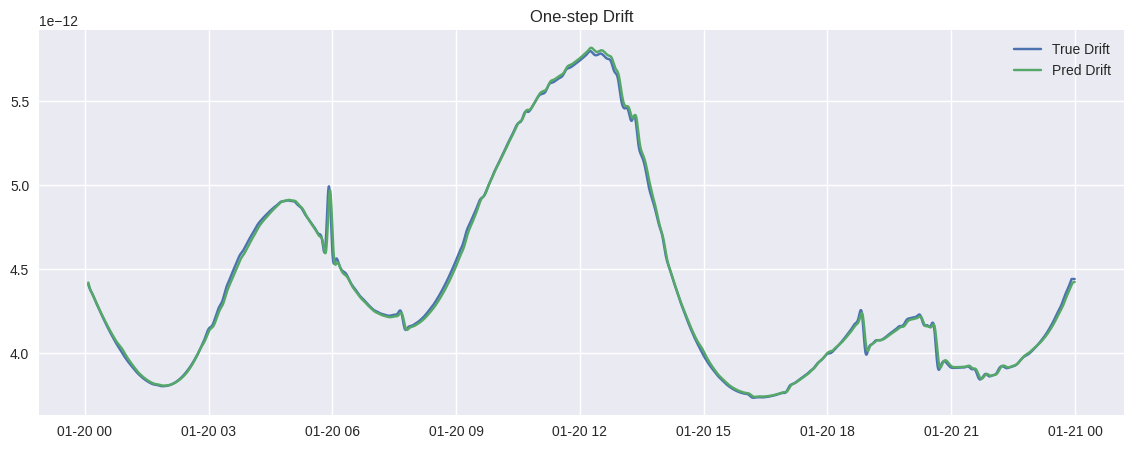

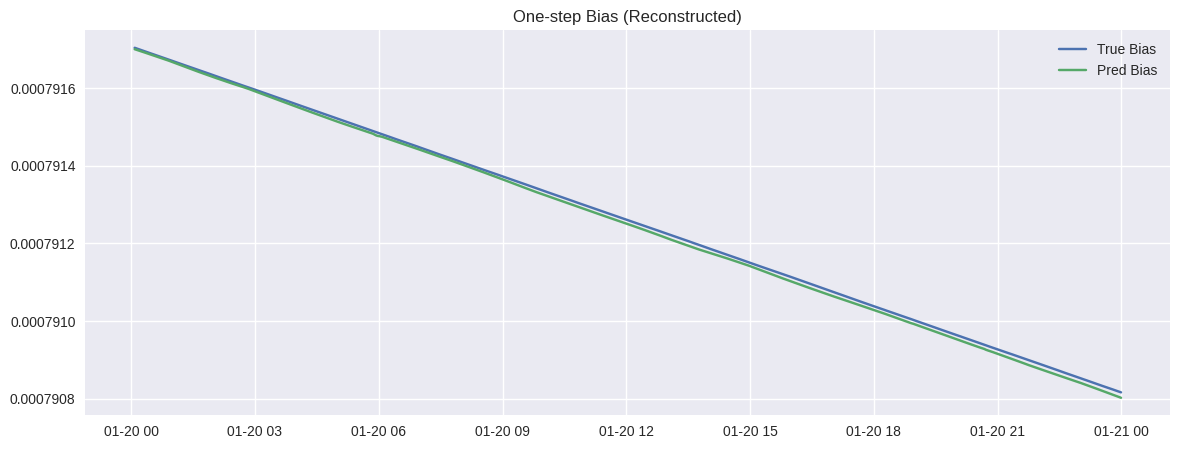

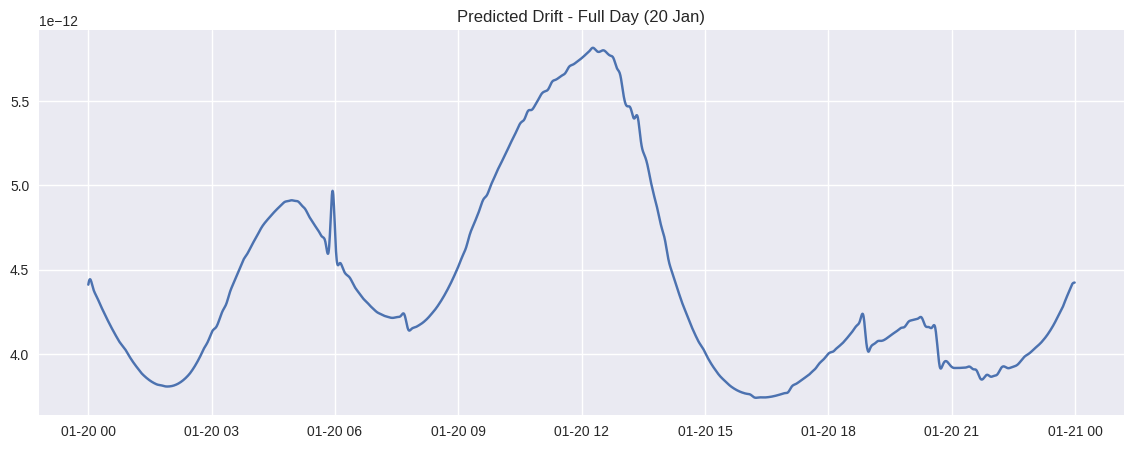

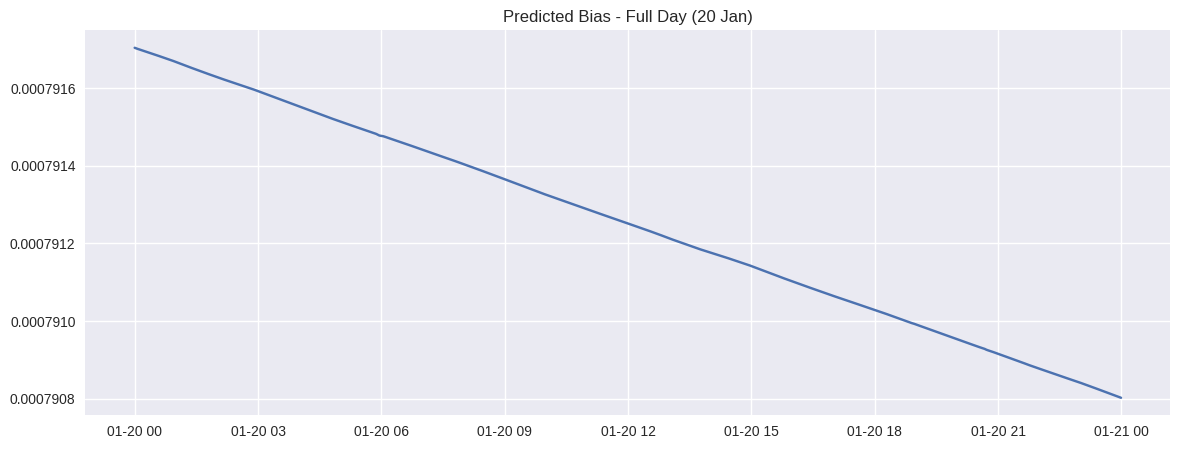

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(df_test['timestamp'][SEQ_LEN:], true_drift, label="True Drift")
plt.plot(df_test['timestamp'][SEQ_LEN:], pred_drift, label="Pred Drift")
plt.legend(); plt.title("One-step Drift"); plt.show()

plt.figure(figsize=(14,5))
plt.plot(df_test['timestamp'][SEQ_LEN:], true_bias, label="True Bias")
plt.plot(df_test['timestamp'][SEQ_LEN:], pred_bias, label="Pred Bias")
plt.legend(); plt.title("One-step Bias (Reconstructed)"); plt.show()

plt.figure(figsize=(14,5))
plt.plot(df_pred['timestamp'], df_pred['predicted_drift_final'])
plt.title("Predicted Drift - Full Day (20 Jan)"); plt.show()

plt.figure(figsize=(14,5))
plt.plot(df_pred['timestamp'], df_pred['predicted_bias'])
plt.title("Predicted Bias - Full Day (20 Jan)"); plt.show()
